In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [246]:
df = pd.read_csv("../data/dfgeopoli.csv")

In [247]:
df.columns

Index(['Unnamed: 0', 'year', 'country_id_o', 'country_o', 'country_id_d',
       'country_d', 'contig', 'distcap', 'dist', 'comlang_off',
       'comlang_ethno', 'comrelig', 'pop_o', 'pop_d', 'gdp_o', 'gdp_d',
       'gdpcap_o', 'gdpcap_d', 'fta_wto', 'tradeflow_comtrade_o',
       'tradeflow_comtrade_d', 'tradeflow_imf_o', 'tradeflow_imf_d',
       'IdealPointDistance', 'arms', 'tot_o', 'tot_d', 'tgdp_ratio_o',
       'tgdp_ratio_d', 'v2x_polyarchy_o', 'v2x_libdem_o', 'v2x_partipdem_o',
       'v2x_delibdem_o', 'v2x_egaldem_o', 'v2x_polyarchy_d', 'v2x_libdem_d',
       'v2x_partipdem_d', 'v2x_delibdem_d', 'v2x_egaldem_d', 'allexports',
       'chemicalexports', 'consumerexports', 'foodexports', 'machineryexports',
       'manufacturesexports', 'logallexports', 'logchemicalexports',
       'logconsumerexports', 'logfoodexports', 'logmachineryexports',
       'logmanufacturesexports', 'log_tradeflow_comtrade_o',
       'v2x_polyarchy_diff', 'v2x_libdem_diff', 'v2x_partipdem_diff',
     

In [248]:
X = df.dropna(subset=['gdpcap_d'])[['geodistance', 'distcap', 'gdpcap_d', 'pop_d']]
vif_df = pd.DataFrame()
vif_df['Feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df) # no large multicollinearity present

       Feature       VIF
0  geodistance  5.608730
1      distcap  5.288182
2     gdpcap_d  1.265124
3        pop_d  1.049985


### Creating lag values

In [249]:
# Sorting by (country_d, year)
df_2 = df.sort_values(by=['country_d', 'year'])

# Set lag variables
df_2['lag_pop_d'] = df_2.groupby('country_d')['pop_d'].shift(1)
df_2['lag_gdpcap_d'] = df_2.groupby('country_d')['gdpcap_d'].shift(1)

df_2 = df_2[df_2.groupby('country_d')['year'].diff() == 1]

df_2 = df_2.dropna(subset=['lag_pop_d', 'lag_gdpcap_d', 'log_tradeflow_comtrade_o', 'log_tradeflow_comtrade_o'])

In [250]:
df_2[['geodistance', 'distcap', 'lag_gdpcap_d', 'lag_pop_d']].corrwith(df_2['log_tradeflow_comtrade_o'])

# makes sense, expect the signs of each variable

geodistance    -0.180455
distcap        -0.319656
lag_gdpcap_d    0.376160
lag_pop_d       0.326401
dtype: float64

In [257]:
# TimeSeriesSplit Cross-validation function
def timeseries_cv(model, X, y, folds = 6):
    tscv = TimeSeriesSplit(n_splits=folds) # around 5 years per fold, there are 32 years in total
    mse_list = []
    r2_list = []
    mae_list = []
    mape_list = []
    
    predictions = pd.Series(index=y.index, dtype=float)

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        if hasattr(X, 'iloc'): # this is because some models uses the np, some uses pandas
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
        if hasattr(y, 'iloc'): # this is because some models uses the np, some uses pandas
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        else:
            y_train, y_test = y[train_index], y[test_index] 
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mse_list.append(mse)
        r2_list.append(r2)
        mae_list.append(mae)
        mape_list.append(mape)
        
        predictions.loc[y_test.index] = pd.Series(y_pred.flatten(), index=y_test.index)

    metrics = {
        'avg_mse': np.mean(mse_list), 
        'avg_r2': np.mean(r2_list), 
        'avg_mae': np.mean(mae_list), 
        'avg_mape': np.mean(mape_list),
        'folds': folds
    }

    return predictions, metrics

In [258]:
# Linear Regression
df_2 = df_2.sort_values(by=['year'])
linearX = df_2[['geodistance', 'distcap', 'lag_gdpcap_d', 'lag_pop_d']]
linearY = df_2[['log_tradeflow_comtrade_o']]

scaler = StandardScaler()
linearX = scaler.fit_transform(linearX)

linearModel = LinearRegression()

linearPredictions, linearMetrics = timeseries_cv(linearModel, linearX, linearY)
print(linearMetrics)

{'avg_mse': 5.32943340526426, 'avg_r2': 0.255932330717029, 'avg_mae': 1.7082527487929962, 'avg_mape': 0.10066628043492935, 'folds': 6}


In [259]:
# XGBoost
xgboostX = df_2[['lag_pop_d', 'lag_gdpcap_d', 'distcap', 'geodistance']].copy()
xgboostX['log_lag_pop_d'] = np.log1p(xgboostX['lag_pop_d'])
xgboostX['log_lag_gdpcap_d'] = np.log1p(xgboostX['lag_gdpcap_d'])

scaler = StandardScaler()
xgboostX[['log_lag_pop_d', 'log_lag_gdpcap_d', 'distcap']] = scaler.fit_transform(xgboostX[['log_lag_pop_d', 'log_lag_gdpcap_d', 'distcap']])
xgboostX = xgboostX[['distcap', 'geodistance', 'log_lag_pop_d', 'log_lag_gdpcap_d']]
xgboostY = df_2[['log_tradeflow_comtrade_o']]

# need to relook at the settings
xgboostModel = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=222
)

xgboostPredictions, xgboostMetrics = timeseries_cv(xgboostModel, xgboostX, xgboostY)
print(xgboostMetrics)

{'avg_mse': 1.8651179543472587, 'avg_r2': 0.7412825637272752, 'avg_mae': 1.009762734865381, 'avg_mape': 0.061283910183323305, 'folds': 6}


In [260]:
# Random forest regression
rfX = df_2[['lag_pop_d', 'lag_gdpcap_d', 'distcap', 'geodistance']].copy()
rfX['log_lag_pop_d'] = np.log1p(rfX['lag_pop_d'])
rfX['log_lag_gdpcap_d'] = np.log1p(rfX['lag_gdpcap_d'])
rfX = rfX[['distcap', 'geodistance', 'log_lag_pop_d', 'log_lag_gdpcap_d']]
rfY = df_2['log_tradeflow_comtrade_o']

# relook at settings
rfModel = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=222)

rfPredictions, rfMetrics = timeseries_cv(rfModel, rfX, rfY)
print(rfMetrics)

{'avg_mse': 1.6788387456256428, 'avg_r2': 0.7643899780292432, 'avg_mae': 0.9164204417979596, 'avg_mape': 0.05609982403492967, 'folds': 6}


In [262]:
# Light GBM
lgbmX = df_2[['lag_pop_d', 'lag_gdpcap_d', 'distcap', 'geodistance']].copy()
lgbmX['log_lag_pop_d'] = np.log1p(lgbmX['lag_pop_d'])
lgbmX['log_lag_gdpcap_d'] = np.log1p(lgbmX['lag_gdpcap_d'])
lgbmX = lgbmX[['distcap', 'geodistance', 'log_lag_pop_d', 'log_lag_gdpcap_d']]
lgbmY = df_2[['log_tradeflow_comtrade_o']]

lgbmModel = LGBMRegressor(n_estimators=100, max_depth=10, random_state=222, verbosity = -1) # verbosity mutes output
lgbmPredictions, lgbmMetrics =  timeseries_cv(lgbmModel, lgbmX, lgbmY)
print(lgbmMetrics)

{'avg_mse': 1.505325759918336, 'avg_r2': 0.7877591208033516, 'avg_mae': 0.8756373065695512, 'avg_mape': 0.053208669760341464, 'folds': 6}


In [263]:
df_2['linearPrediction'] = linearPredictions
df_2['xgboostPrediction'] = xgboostPredictions
df_2['rfPrediction'] = rfPredictions
df_2['lgbmPrediction'] = lgbmPredictions

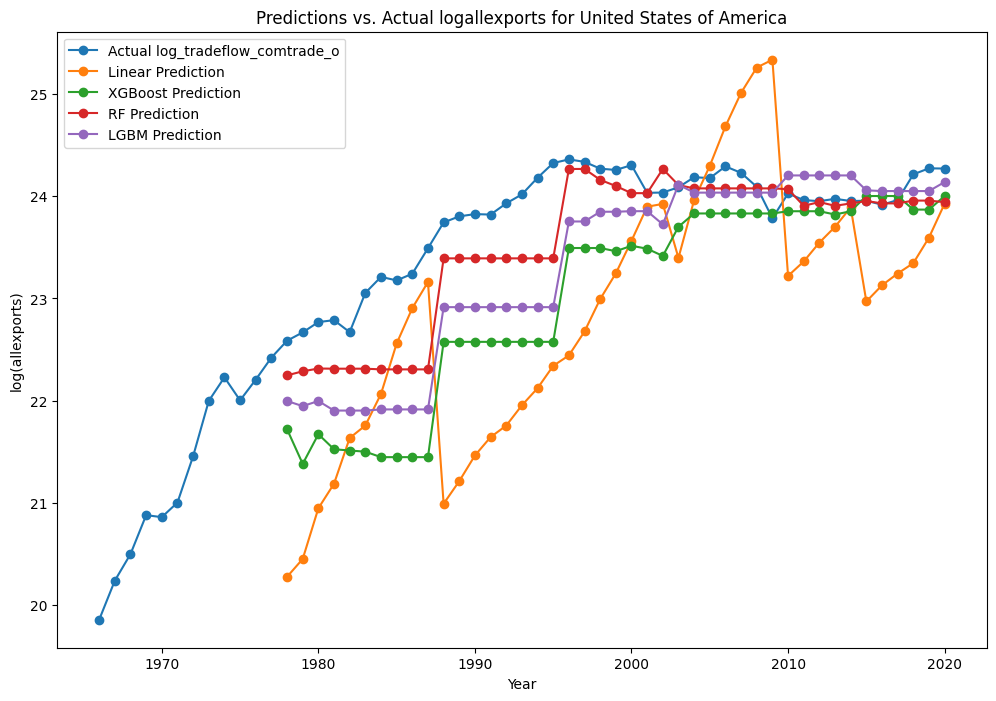

In [267]:
df_filtered = df_2[df_2['country_d'] == 'United States of America']

plt.figure(figsize=(12, 8))
plt.plot(df_filtered['year'], df_filtered['log_tradeflow_comtrade_o'], label='Actual log_tradeflow_comtrade_o', marker='o')
plt.plot(df_filtered['year'], df_filtered['linearPrediction'], label='Linear Prediction', marker='o')
plt.plot(df_filtered['year'], df_filtered['xgboostPrediction'], label='XGBoost Prediction', marker='o')
plt.plot(df_filtered['year'], df_filtered['rfPrediction'], label='RF Prediction', marker='o')
plt.plot(df_filtered['year'], df_filtered['lgbmPrediction'], label='LGBM Prediction', marker='o')

# Label the plot
plt.xlabel('Year')
plt.ylabel('log(allexports)')
plt.title('Predictions vs. Actual logallexports for United States of America')
plt.legend()
plt.show()